In [115]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [124]:
using_colab = False

In [125]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [126]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [127]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Trimming the video

In [128]:
# ============= STEP 1: FIND FIRST ANNOTATED FRAME AND PREPROCESS =============

INPUT_FOLDER = "/home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp"

import json
import cv2
import os
import shutil
from datetime import datetime

print(f"\n{'='*70}")
print(f"STEP 1: PREPROCESSING - Find annotated frame and trim video")
print(f"{'='*70}")

# Load JSON to find first annotated frame
print(f"\n📄 Loading annotations from: {os.path.basename(ANNOTATION_FILE)}")

with open(ANNOTATION_FILE, 'r') as f:
    data = json.load(f)

# Find first frame with bounding boxes
first_annotated_frame_no = None
num_boxes = 0

for frame_data in data["frames"]:
    boxes = frame_data.get("annotation", {}).get("boxes", [])
    if len(boxes) > 0:
        first_annotated_frame_no = frame_data["frameNo"]
        num_boxes = len(boxes)
        print(f"✓ Found first annotated frame: frameNo {first_annotated_frame_no}")
        print(f"  Number of objects: {num_boxes}")
        break

if first_annotated_frame_no is None:
    raise ValueError("No annotated frames found in JSON!")

# Load video properties
cap = cv2.VideoCapture(VIDEO_PATH)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"\n📹 Original video properties:")
print(f"  Total frames: {total_frames}")
print(f"  FPS: {fps}")
print(f"  Resolution: {width}x{height}")

# Calculate trim range (frameNo is 1-indexed, video frames are 0-indexed)
trim_start_frame = first_annotated_frame_no - 1  # Convert to 0-indexed
trim_end_frame = total_frames - 1
frames_to_extract = trim_end_frame - trim_start_frame + 1

print(f"\n✂️  Trimming video:")
print(f"  Start from frame: {trim_start_frame} (0-indexed) / frameNo {first_annotated_frame_no} (JSON)")
print(f"  End at frame: {trim_end_frame}")
print(f"  Frames to extract: {frames_to_extract}")

# Create processed folder
processed_dir = os.path.join(INPUT_FOLDER, "processed")
os.makedirs(processed_dir, exist_ok=True)
print(f"\n📁 Created processed folder: {processed_dir}")

# ============= TRIM VIDEO =============
print(f"\n⏳ Trimming video from frame {trim_start_frame}...")

video_name_base = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
trimmed_video_path = os.path.join(processed_dir, f"{video_name_base}_processed.mp4")

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_writer = cv2.VideoWriter(trimmed_video_path, fourcc, fps, (width, height))

# Read and write frames from trim_start_frame onwards
cap.set(cv2.CAP_PROP_POS_FRAMES, trim_start_frame)
frames_written = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    out_writer.write(frame)
    frames_written += 1
    
    if frames_written % 50 == 0:
        print(f"  Progress: {frames_written}/{frames_to_extract} frames", end='\r')

cap.release()
out_writer.release()

print(f"\n✓ Trimmed video saved: {frames_written} frames")
print(f"  {os.path.basename(trimmed_video_path)}")

# ============= CREATE PROCESSED JSON (RENUMBER FRAMES) =============
print(f"\n📝 Creating processed JSON with renumbered frames...")

processed_frames = []
frame_offset = first_annotated_frame_no - 1  # How many frames we skipped

for frame_data in data["frames"]:
    original_frame_no = frame_data["frameNo"]
    
    # Only include frames from first_annotated_frame_no onwards
    if original_frame_no >= first_annotated_frame_no:
        # Renumber: frameNo 8 becomes 1, frameNo 9 becomes 2, etc.
        new_frame_no = original_frame_no - frame_offset
        
        new_frame_data = frame_data.copy()
        new_frame_data["frameNo"] = new_frame_no
        new_frame_data["originalFrameNo"] = original_frame_no  # Keep original for reference
        
        processed_frames.append(new_frame_data)

# Create processed JSON data
processed_json = {
    "taskId": data.get("taskId", ""),
    "campaignId": data.get("campaignId", ""),
    "videoName": f"{video_name_base}_processed",
    "metadata": {
        "fps": fps,
        "totalFrames": frames_written,
        "segmentStart": 1,
        "segmentEnd": frames_written,
        "originalFirstFrame": first_annotated_frame_no,
        "frameOffset": frame_offset,
        "processedDate": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "sourceVideo": os.path.basename(VIDEO_PATH),
        "sourceJSON": os.path.basename(ANNOTATION_FILE)
    },
    "frames": processed_frames
}

# Save processed JSON
processed_json_path = os.path.join(processed_dir, f"{video_name_base}_processed.json")
with open(processed_json_path, 'w') as f:
    json.dump(processed_json, f, indent=2)

print(f"✓ Processed JSON saved: {len(processed_frames)} frames")
print(f"  {os.path.basename(processed_json_path)}")

# Count annotated frames
num_annotated = sum(1 for f in processed_frames if len(f.get("annotation", {}).get("boxes", [])) > 0)
print(f"  Frames with annotations: {num_annotated}/{len(processed_frames)}")

# ============= CREATE ANNOTATIONS.TXT SUMMARY =============
annotations_txt_path = os.path.join(processed_dir, "annotations.txt")

with open(annotations_txt_path, 'w') as f:
    f.write(f"PROCESSED VIDEO ANNOTATIONS\n")
    f.write(f"{'='*70}\n\n")
    f.write(f"Source Video: {os.path.basename(VIDEO_PATH)}\n")
    f.write(f"Source JSON: {os.path.basename(ANNOTATION_FILE)}\n")
    f.write(f"Processed Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"Video Properties:\n")
    f.write(f"  Resolution: {width}x{height}\n")
    f.write(f"  FPS: {fps}\n")
    f.write(f"  Total Frames: {frames_written}\n\n")
    f.write(f"Processing:\n")
    f.write(f"  Original first annotated frame: frameNo {first_annotated_frame_no} (JSON)\n")
    f.write(f"  Now starts at: frameNo 1 (processed JSON)\n")
    f.write(f"  Frame offset: {frame_offset} frames removed\n\n")
    f.write(f"Annotations:\n")
    f.write(f"  Total annotated frames: {num_annotated}\n")
    f.write(f"  Objects in first frame: {num_boxes}\n\n")
    
    # List all annotated frames
    f.write(f"Annotated Frame List:\n")
    for frame_data in processed_frames:
        boxes = frame_data.get("annotation", {}).get("boxes", [])
        if len(boxes) > 0:
            original_no = frame_data.get("originalFrameNo", "N/A")
            new_no = frame_data["frameNo"]
            f.write(f"  frameNo {new_no} (was {original_no}): {len(boxes)} objects\n")
            for box in boxes:
                label = box.get("label", "unknown")
                box_type = box.get("boxType", "unknown")
                f.write(f"    - {box_type} (label: {label})\n")

print(f"✓ Annotations summary saved:")
print(f"  {os.path.basename(annotations_txt_path)}")

# ============= UPDATE PATHS FOR REST OF PIPELINE =============
# Update VIDEO_PATH and ANNOTATION_FILE to use processed versions
VIDEO_PATH = trimmed_video_path
ANNOTATION_FILE = processed_json_path

print(f"\n{'='*70}")
print(f"✅ PREPROCESSING COMPLETE")
print(f"{'='*70}")
print(f"\nProcessed files:")
print(f"  📹 Video: {os.path.basename(trimmed_video_path)} ({frames_written} frames)")
print(f"  📄 JSON: {os.path.basename(processed_json_path)} ({len(processed_frames)} frames)")
print(f"  📝 TXT: {os.path.basename(annotations_txt_path)}")
print(f"\n💡 First annotated frame is NOW frame 0 (frameNo 1 in JSON)")
print(f"{'='*70}\n")


STEP 1: PREPROCESSING - Find annotated frame and trim video

📄 Loading annotations from: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_annotations.json
✓ Found first annotated frame: frameNo 8
  Number of objects: 5

📹 Original video properties:
  Total frames: 16
  FPS: 20.0
  Resolution: 640x480

✂️  Trimming video:
  Start from frame: 7 (0-indexed) / frameNo 8 (JSON)
  End at frame: 15
  Frames to extract: 9

📁 Created processed folder: /home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp/processed

⏳ Trimming video from frame 7...

✓ Trimmed video saved: 9 frames
  24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed.mp4

📝 Creating processed JSON with renumbered frames...
✓ Processed JSON saved: 9 frames
  24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed.json
  Frames with annotations: 1/9
✓ Annotations summary saved:
  annotations.txt

✅ PREPROCESSING COMPLETE

Processed files:
  📹 Video: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed.mp4 (9 

In [129]:
# ============= STEP 2: EXTRACT FRAMES FROM PROCESSED VIDEO =============

import cv2, os

print(f"\n{'='*70}")
print(f"STEP 2: EXTRACTING FRAMES")
print(f"{'='*70}")

# Extract video name without extension
video_name = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
video_dir_base = os.path.dirname(VIDEO_PATH)

# Create directory structure: processed/videoname/frames
frames_dir = os.path.join(video_dir_base, video_name, "frames")
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(VIDEO_PATH)
original_fps = cap.get(cv2.CAP_PROP_FPS)
target_fps = 20

# Calculate frame interval to achieve target FPS
frame_interval = int(original_fps / target_fps) if original_fps > target_fps else 1

idx = 0
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Only save frames at the target FPS rate
    if idx % frame_interval == 0:
        cv2.imwrite(f"{frames_dir}/{frame_count:05d}.jpg", frame)
        frame_count += 1
    
    idx += 1

cap.release()

print(f"\nOriginal FPS: {original_fps}")
print(f"Target FPS: {target_fps}")
print(f"Total frames extracted: {frame_count}")
print(f"Frames saved to: {frames_dir}")
print(f"{'='*70}\n")


STEP 2: EXTRACTING FRAMES

Original FPS: 20.0
Target FPS: 20
Total frames extracted: 9
Frames saved to: /home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp/processed/24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed/frames




STEP 3: LOADING FRAMES

Total frames loaded: 9
✓ First annotated frame: frame_idx 0 (frameNo 1 in JSON)
  Number of objects: 5


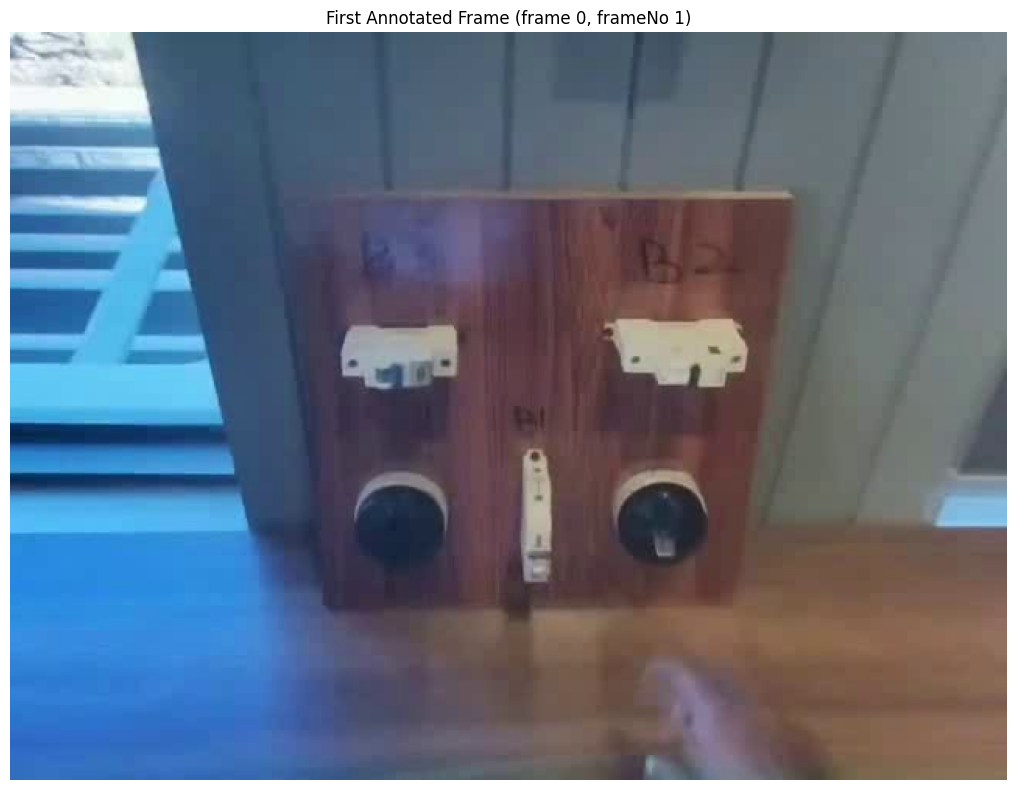


✓ Frame 0 will be used for SAM2 initialization



In [130]:
# ============= STEP 3: LOAD FRAMES AND VERIFY =============

print(f"\n{'='*70}")
print(f"STEP 3: LOADING FRAMES")
print(f"{'='*70}")

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(frames_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

print(f"\nTotal frames loaded: {len(frame_names)}")

# Load JSON to get first annotated frame (should be frameNo 1 now)
with open(ANNOTATION_FILE, 'r') as f:
    data = json.load(f)

# Find first annotated frame in processed JSON
START_FRAME = None
for frame_data in data["frames"]:
    boxes = frame_data.get("annotation", {}).get("boxes", [])
    if len(boxes) > 0:
        # frameNo in processed JSON is 1-indexed, convert to 0-indexed for frame array
        START_FRAME = frame_data["frameNo"] - 1
        num_boxes = len(boxes)
        print(f"✓ First annotated frame: frame_idx {START_FRAME} (frameNo {frame_data['frameNo']} in JSON)")
        print(f"  Number of objects: {num_boxes}")
        break

if START_FRAME is None:
    raise ValueError("No annotated frames found!")

# Display the first annotated frame
plt.figure(figsize=(12, 8))
plt.title(f"First Annotated Frame (frame {START_FRAME}, frameNo {START_FRAME + 1})")
plt.imshow(Image.open(os.path.join(frames_dir, frame_names[START_FRAME])))
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✓ Frame {START_FRAME} will be used for SAM2 initialization")
print(f"{'='*70}\n")

### Loading the SAM 2 video predictor

In [131]:
from sam2.build_sam import build_sam2_video_predictor
sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"

model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [132]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [133]:
# ============= CONFIGURATION =============

# Input: Video data folder containing video file and annotation JSON
INPUT_FOLDER = "/home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp/processed"

print(f"Input folder: {INPUT_FOLDER}")

# Auto-detect video and annotation files in the folder
import glob

# Find JSON annotation file
json_files = glob.glob(os.path.join(INPUT_FOLDER, "*.json"))
if len(json_files) == 0:
    raise ValueError(f"No JSON annotation file found in {INPUT_FOLDER}")
elif len(json_files) > 1:
    print(f"⚠ Multiple JSON files found: {json_files}")
    print(f"  Using first one: {json_files[0]}")

ANNOTATION_FILE = json_files[0]
print(f"✓ Found annotation: {os.path.basename(ANNOTATION_FILE)}")

# Find ANY video file in the folder (simpler approach)
video_extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv']
video_files = []

for ext in video_extensions:
    video_files.extend(glob.glob(os.path.join(INPUT_FOLDER, ext)))

if len(video_files) == 0:
    raise ValueError(f"No video file found in {INPUT_FOLDER}\nSearched for extensions: .mp4, .avi, .mov, .mkv")
elif len(video_files) > 1:
    print(f"⚠ Multiple video files found: {[os.path.basename(f) for f in video_files]}")
    print(f"  Using first one: {os.path.basename(video_files[0])}")

VIDEO_PATH = video_files[0]
print(f"✓ Found video: {os.path.basename(VIDEO_PATH)}")

# Model configuration - Choose one:
# Option 1: Tiny 512 (LOWEST MEMORY - Recommended for 2000+ frames)

CHECKPOINT = "../checkpoints/sam2.1_hiera_tiny.pt"

MODEL_CFG = "configs/sam2.1/sam2.1_hiera_t.yaml"

# Option 2: Tiny 1024 (Low memory, better quality)
# MODEL_CFG = "configs/sam2.1/sam2.1_hiera_t.yaml"
# CHECKPOINT = "checkpoints/sam2.1_hiera_tiny.pt"

# Option 3: Small (More memory, best quality)
# MODEL_CFG = "configs/sam2.1/sam2.1_hiera_s.yaml"
# CHECKPOINT = "checkpoints/sam2.1_hiera_small.pt"

# Output configuration - mirror input folder structure
folder_name = os.path.basename(INPUT_FOLDER.rstrip('/'))
OUTPUT_DIR = folder_name  # Save directly to folder with same name as input
SAVE_MASKS = True  # Save individual masks per frame
SAVE_RAW_VIDEO = True  # Copy original video to raw/ subfolder
SAVE_MASKS_ONLY_VIDEO = True  # Save binary masks video (black background)
SAVE_OVERLAY_VIDEO = True  # Save video with mask overlays
VISUALIZATION_INTERVAL = 100  # Show preview every N frames

# Performance optimization
VOS_OPTIMIZED = True  # Enable model compilation (faster after warmup)

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"\n✓ Configuration set")
print(f"  Model: {MODEL_CFG }")
print(f"  Output folder: {OUTPUT_DIR}")


Input folder: /home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp/processed
✓ Found annotation: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed.json
✓ Found video: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed.mp4

✓ Configuration set
  Model: configs/sam2.1/sam2.1_hiera_t.yaml
  Output folder: processed


In [123]:
import cv2, os

# Extract video name without extension
video_name = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
video_dir_base = os.path.dirname(VIDEO_PATH)

# Create directory structure: video_dir_path/videoname/frames
frames_dir = os.path.join(video_dir_base, video_name, "frames")
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(VIDEO_PATH)
original_fps = cap.get(cv2.CAP_PROP_FPS)
target_fps = 20

# Calculate frame interval to achieve target FPS
frame_interval = int(original_fps / target_fps) if original_fps > target_fps else 1

idx = 0
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Only save frames at the target FPS rate
    if idx % frame_interval == 0:
        cv2.imwrite(f"{frames_dir}/{frame_count:05d}.jpg", frame)
        frame_count += 1
    
    idx += 1

cap.release()

print(f"Original FPS: {original_fps}")
print(f"Target FPS: {target_fps}")
print(f"Total frames extracted: {frame_count}")
print(f"Frames saved to: {frames_dir}")

Original FPS: 20.0
Target FPS: 20
Total frames extracted: 16
Frames saved to: /home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp/24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed/frames


#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [134]:
inference_state = predictor.init_state(video_path=frames_dir)

frame loading (JPEG):   0%|          | 0/9 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 9/9 [00:00<00:00, 53.48it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [135]:
predictor.reset_state(inference_state)


🎯 Initializing SAM2 predictions from 5 annotated boxes...
  Object 1 (label=9): box=[373, 177, 477, 232]
  Object 2 (label=10): box=[202, 180, 296, 235]
  Object 3 (label=8): box=[319, 262, 353, 359]
  Object 4 (label=7): box=[382, 275, 450, 345]
  Object 5 (label=6): box=[215, 277, 284, 349]

✓ Initialized 5 object masks


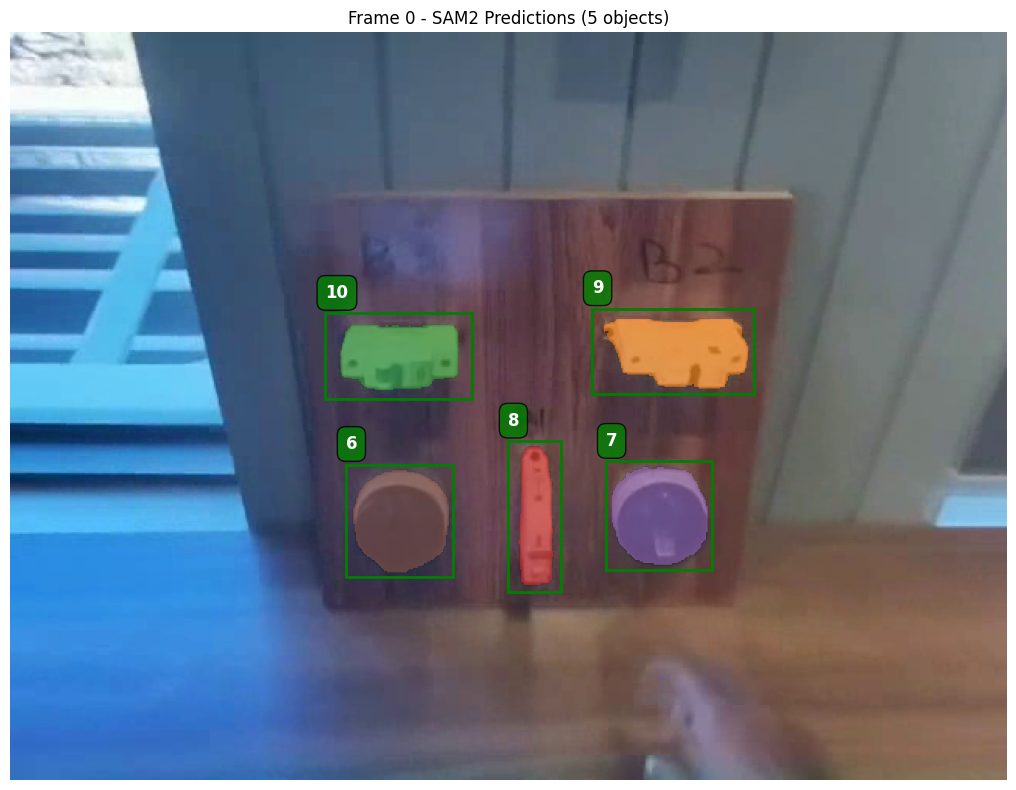


✓ Initial segmentation complete!
  Next: Run propagate_in_video to track objects across all frames


In [136]:
# ============= INITIALIZE SAM2 WITH BOUNDING BOXES =============

print(f"\n🎯 Initializing SAM2 predictions from {num_boxes} annotated boxes...")

# Extract boxes from the annotated frame
annotated_boxes = []
for frame_data in data["frames"]:
    if frame_data["frameNo"] - 1 == START_FRAME:
        annotated_boxes = frame_data["annotation"]["boxes"]
        break

# Process each bounding box
all_masks = {}
for idx, box_data in enumerate(annotated_boxes):
    # Extract normalized coordinates from 4 points
    coords = box_data["coordinates"]
    
    # Get all x and y coordinates
    x_coords = [coords[f"point{i}"]["x"] for i in range(1, 5)]
    y_coords = [coords[f"point{i}"]["y"] for i in range(1, 5)]
    
    # Get bounding box (normalized 0-1)
    x_min_norm = min(x_coords)
    x_max_norm = max(x_coords)
    y_min_norm = min(y_coords)
    y_max_norm = max(y_coords)
    
    # Convert to pixel coordinates
    x_min = int(x_min_norm * width)
    y_min = int(y_min_norm * height)
    x_max = int(x_max_norm * width)
    y_max = int(y_max_norm * height)
    
    # Convert to SAM2 format (x_min, y_min, x_max, y_max)
    box = np.array([x_min, y_min, x_max, y_max], dtype=np.float32)
    
    # Use sequential numbering for obj_id (MUST be integer for SAM2)
    obj_id = idx + 1
    # Get label from JSON for display
    label = str(box_data.get("label", f"object_{obj_id}"))
    
    print(f"  Object {obj_id} (label={label}): box=[{x_min}, {y_min}, {x_max}, {y_max}]")
    
    # Add box to SAM2 predictor
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=START_FRAME,
        obj_id=obj_id,
        box=box,
    )
    
    # FIXED: Find the correct mask index for this obj_id
    # out_obj_ids contains the IDs returned, find where our obj_id is
    mask_idx = list(out_obj_ids).index(obj_id)
    
    # Store the CORRECT mask for this object
    all_masks[obj_id] = {
        'mask_logits': out_mask_logits[mask_idx],
        'mask': (out_mask_logits[mask_idx] > 0.0).cpu().numpy(),
        'box': box,
        'label': label
    }

print(f"\n✓ Initialized {len(all_masks)} object masks")

# ============= VISUALIZE PREDICTIONS =============
plt.figure(figsize=(12, 8))
plt.imshow(first_frame_rgb)
plt.title(f"Frame {START_FRAME} - SAM2 Predictions ({len(all_masks)} objects)")

# Show each mask and box
for obj_id, mask_info in all_masks.items():
    # Draw mask
    show_mask(mask_info['mask'], plt.gca(), obj_id=obj_id)
    
    # Draw box
    show_box(mask_info['box'], plt.gca())
    
    # Add label
    box = mask_info['box']
    plt.text(box[0], box[1]-10, mask_info['label'], 
             color='white', fontsize=12, weight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='green', alpha=0.8))

plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✓ Initial segmentation complete!")
print(f"  Next: Run propagate_in_video to track objects across all frames")

In [139]:
# ============= PROPAGATE AND CREATE 8 VIDEOS (3 OVERLAYS + 5 OBJECTS) =============

import cv2
import numpy as np

print(f"\n{'='*70}")
print(f"PROPAGATING MASKS AND CREATING 8 VIDEOS")
print(f"{'='*70}")

# Create output directory
video_output_dir = os.path.join(processed_dir, "output_videos")
os.makedirs(video_output_dir, exist_ok=True)

# Video settings
output_fps = 20
video_name_base = os.path.splitext(os.path.basename(VIDEO_PATH))[0]

# Define output paths for 3 overlay videos
overlay_both_path = os.path.join(video_output_dir, f"{video_name_base}_masks_and_boxes.mp4")
overlay_masks_only_path = os.path.join(video_output_dir, f"{video_name_base}_masks_only.mp4")
overlay_boxes_only_path = os.path.join(video_output_dir, f"{video_name_base}_boxes_only.mp4")

# Get video dimensions from first frame
first_img = cv2.imread(os.path.join(frames_dir, frame_names[0]))
height, width = first_img.shape[:2]

# Initialize video writers for 3 overlay videos
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer_both = cv2.VideoWriter(overlay_both_path, fourcc, output_fps, (width, height))
writer_masks = cv2.VideoWriter(overlay_masks_only_path, fourcc, output_fps, (width, height))
writer_boxes = cv2.VideoWriter(overlay_boxes_only_path, fourcc, output_fps, (width, height))

# Initialize video writers for each individual object (black background with only that object visible)
object_writers = {}
object_video_paths = {}

for obj_id, mask_info in all_masks.items():
    label = mask_info.get('label', f'obj_{obj_id}')
    # Clean label for filename
    clean_label = ''.join(c if c.isalnum() or c in ['-', '_'] else '_' for c in str(label))
    
    obj_video_path = os.path.join(video_output_dir, f"{video_name_base}_object_{clean_label}_isolated.mp4")
    obj_writer = cv2.VideoWriter(obj_video_path, fourcc, output_fps, (width, height))
    
    if obj_writer.isOpened():
        object_writers[obj_id] = obj_writer
        object_video_paths[obj_id] = obj_video_path
    else:
        print(f"⚠️  Failed to initialize writer for object {obj_id} ({label})")

# Check if all writers opened successfully
if not (writer_both.isOpened() and writer_masks.isOpened() and writer_boxes.isOpened()):
    raise RuntimeError("Failed to initialize overlay video writers")

print(f"\n⏳ Propagating masks and writing {3 + len(object_writers)} videos...")
print(f"\n📹 Overlay Videos:")
print(f"  1. Masks + Boxes: {os.path.basename(overlay_both_path)}")
print(f"  2. Masks Only: {os.path.basename(overlay_masks_only_path)}")
print(f"  3. Boxes Only: {os.path.basename(overlay_boxes_only_path)}")
print(f"\n🎯 Individual Object Videos (isolated):")
for obj_id, obj_path in object_video_paths.items():
    label = all_masks[obj_id].get('label', f'obj_{obj_id}')
    print(f"  {obj_id}. Object {label}: {os.path.basename(obj_path)}")
print(f"\n  Resolution: {width}x{height}")
print(f"  FPS: {output_fps}")
print(f"  Objects: {len(all_masks)}")

# Propagate and write all videos simultaneously
frame_count = 0
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    # Load original frame
    frame_path = os.path.join(frames_dir, frame_names[out_frame_idx])
    frame = cv2.imread(frame_path)
    
    if frame is None:
        print(f"\n⚠ Warning: Could not read frame {out_frame_idx}, skipping...")
        continue
    
    # Create 3 separate overlay frames
    overlay_both = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    overlay_masks = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    overlay_boxes = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Store masks for individual object videos
    frame_masks = {}
    
    # Draw each object's mask and/or box
    for i, out_obj_id in enumerate(out_obj_ids):
        # Get mask for this object
        mask = (out_mask_logits[i] > 0.0).cpu().numpy().squeeze()
        frame_masks[out_obj_id] = mask
        
        # Get color for this object
        cmap = plt.get_cmap("tab10")
        color = np.array([*cmap(out_obj_id)[:3]])
        
        # Apply colored mask overlay
        mask_3channel = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        color_rgb = color.reshape(1, 1, 3)
        mask_colored = (mask_3channel * color_rgb * 255).astype(np.uint8)
        
        # Blend mask with original (60% opacity) for masks videos
        overlay_both = cv2.addWeighted(overlay_both, 1.0, mask_colored, 0.6, 0)
        overlay_masks = cv2.addWeighted(overlay_masks, 1.0, mask_colored, 0.6, 0)
        
        # Draw bounding box and label on appropriate videos
        if out_obj_id in all_masks:
            mask_info = all_masks[out_obj_id]
            box = mask_info['box']
            x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            label = mask_info.get('label', f'obj_{out_obj_id}')
            
            # Draw on "both" video
            cv2.rectangle(overlay_both, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(overlay_both, str(label), (x1, y1-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Draw on "boxes only" video
            cv2.rectangle(overlay_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(overlay_boxes, str(label), (x1, y1-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Convert back to BGR and write 3 overlay videos
    writer_both.write(cv2.cvtColor(overlay_both, cv2.COLOR_RGB2BGR))
    writer_masks.write(cv2.cvtColor(overlay_masks, cv2.COLOR_RGB2BGR))
    writer_boxes.write(cv2.cvtColor(overlay_boxes, cv2.COLOR_RGB2BGR))
    
    # Write individual object videos (black background with only that object visible)
    for obj_id, obj_writer in object_writers.items():
        # Create black background
        isolated_frame = np.zeros_like(frame)
        
        # If this object has a mask in current frame, show it
        if obj_id in frame_masks:
            mask = frame_masks[obj_id]
            mask_bool = mask.astype(bool)
            # Copy only the pixels where mask is true
            isolated_frame[mask_bool] = frame[mask_bool]
        
        # Write to object-specific video
        obj_writer.write(isolated_frame)
    
    frame_count += 1
    
    # Progress indicator
    if frame_count % 10 == 0:
        progress = frame_count / len(frame_names) * 100
        print(f"  Progress: {frame_count}/{len(frame_names)} frames ({progress:.1f}%)", end='\r')

# Release all video writers
writer_both.release()
writer_masks.release()
writer_boxes.release()
for obj_writer in object_writers.values():
    obj_writer.release()

# Verify outputs
both_exists = os.path.exists(overlay_both_path)
masks_exists = os.path.exists(overlay_masks_only_path)
boxes_exists = os.path.exists(overlay_boxes_only_path)

both_size = os.path.getsize(overlay_both_path) if both_exists else 0
masks_size = os.path.getsize(overlay_masks_only_path) if masks_exists else 0
boxes_size = os.path.getsize(overlay_boxes_only_path) if boxes_exists else 0

print(f"\n\n{'='*70}")
total_videos = 3 + len(object_video_paths)
successful = sum([both_exists, masks_exists, boxes_exists]) + sum([os.path.exists(p) for p in object_video_paths.values()])
print(f"✅ {successful}/{total_videos} VIDEOS CREATED SUCCESSFULLY")
print(f"{'='*70}")

print(f"\n📹 Overlay Videos:")
print(f"  1. Masks + Boxes:")
print(f"     Path: {os.path.basename(overlay_both_path)}")
print(f"     Size: {both_size/1024/1024:.2f} MB")
print(f"     Status: {'✓' if both_exists else '✗'}")

print(f"\n  2. Masks Only:")
print(f"     Path: {os.path.basename(overlay_masks_only_path)}")
print(f"     Size: {masks_size/1024/1024:.2f} MB")
print(f"     Status: {'✓' if masks_exists else '✗'}")

print(f"\n  3. Boxes Only:")
print(f"     Path: {os.path.basename(overlay_boxes_only_path)}")
print(f"     Size: {boxes_size/1024/1024:.2f} MB")
print(f"     Status: {'✓' if boxes_exists else '✗'}")

print(f"\n🎯 Individual Object Videos (black background, only object visible):")
for obj_id, obj_video_path in object_video_paths.items():
    obj_exists = os.path.exists(obj_video_path)
    obj_size = os.path.getsize(obj_video_path) if obj_exists else 0
    label = all_masks[obj_id].get('label', f'obj_{obj_id}')
    
    print(f"\n  Object {label} (ID: {obj_id}):")
    print(f"     Path: {os.path.basename(obj_video_path)}")
    print(f"     Size: {obj_size/1024/1024:.2f} MB")
    print(f"     Status: {'✓' if obj_exists else '✗'}")

print(f"\n{'='*70}")
print(f"Frames processed: {frame_count}")
print(f"Resolution: {width}x{height}")
print(f"FPS: {output_fps}")
print(f"Objects tracked: {len(all_masks)}")
print(f"Total videos created: {total_videos}")
print(f"{'='*70}")
print(f"\n💡 All videos saved to: {video_output_dir}")


PROPAGATING MASKS AND CREATING 8 VIDEOS

⏳ Propagating masks and writing 8 videos...

📹 Overlay Videos:
  1. Masks + Boxes: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_and_boxes.mp4
  2. Masks Only: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_only.mp4
  3. Boxes Only: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_boxes_only.mp4

🎯 Individual Object Videos (isolated):
  1. Object 9: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_9_isolated.mp4
  2. Object 10: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_10_isolated.mp4
  3. Object 8: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_8_isolated.mp4
  4. Object 7: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_7_isolated.mp4
  5. Object 6: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_6_isolated.mp4

  Resolution: 640x480
  FPS: 20
  Objects: 5


propagate in video: 100%|██████████| 9/9 [00:02<00:00,  4.09it/s]



✅ 8/8 VIDEOS CREATED SUCCESSFULLY

📹 Overlay Videos:
  1. Masks + Boxes:
     Path: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_and_boxes.mp4
     Size: 0.17 MB
     Status: ✓

  2. Masks Only:
     Path: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_only.mp4
     Size: 0.12 MB
     Status: ✓

  3. Boxes Only:
     Path: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_boxes_only.mp4
     Size: 0.15 MB
     Status: ✓

🎯 Individual Object Videos (black background, only object visible):

  Object 9 (ID: 1):
     Path: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_9_isolated.mp4
     Size: 0.01 MB
     Status: ✓

  Object 10 (ID: 2):
     Path: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_10_isolated.mp4
     Size: 0.01 MB
     Status: ✓

  Object 8 (ID: 3):
     Path: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_8_isolated.mp4
     Size: 0.01 MB
     S

In [140]:
# ============= PROPAGATE AND CREATE 4 VIDEOS + 2 FOLDERS (5 OBJECT VIDEOS EACH) =============

import cv2
import numpy as np

print(f"\n{'='*70}")
print(f"PROPAGATING MASKS AND CREATING VIDEOS")
print(f"{'='*70}")

# Create output directory structure
video_output_dir = os.path.join(processed_dir, "output_videos")
objects_dir = os.path.join(video_output_dir, "objects")
masks_only_dir = os.path.join(video_output_dir, "masks_only")

os.makedirs(video_output_dir, exist_ok=True)
os.makedirs(objects_dir, exist_ok=True)
os.makedirs(masks_only_dir, exist_ok=True)

# Video settings
output_fps = 20
video_name_base = os.path.splitext(os.path.basename(VIDEO_PATH))[0]

# Define output paths for 4 overlay videos
overlay_both_path = os.path.join(video_output_dir, f"{video_name_base}_masks_and_boxes.mp4")
overlay_boxes_path = os.path.join(video_output_dir, f"{video_name_base}_boxes.mp4")
overlay_masks_blended_path = os.path.join(video_output_dir, f"{video_name_base}_masks_overlaid.mp4")
overlay_masks_only_path = os.path.join(video_output_dir, f"{video_name_base}_masks_only.mp4")

# Get video dimensions from first frame
first_img = cv2.imread(os.path.join(frames_dir, frame_names[0]))
height, width = first_img.shape[:2]

# Initialize video writers for 4 overlay videos
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer_both = cv2.VideoWriter(overlay_both_path, fourcc, output_fps, (width, height))
writer_boxes = cv2.VideoWriter(overlay_boxes_path, fourcc, output_fps, (width, height))
writer_masks_blended = cv2.VideoWriter(overlay_masks_blended_path, fourcc, output_fps, (width, height))
writer_masks_only = cv2.VideoWriter(overlay_masks_only_path, fourcc, output_fps, (width, height))

# Check if overlay writers opened successfully
if not (writer_both.isOpened() and writer_boxes.isOpened() and 
        writer_masks_blended.isOpened() and writer_masks_only.isOpened()):
    raise RuntimeError("Failed to initialize overlay video writers")

# Initialize video writers for individual objects (in objects/ folder)
object_writers = {}
object_video_paths = {}

for obj_id, mask_info in all_masks.items():
    label = mask_info.get('label', f'obj_{obj_id}')
    clean_label = ''.join(c if c.isalnum() or c in ['-', '_'] else '_' for c in str(label))
    
    obj_video_path = os.path.join(objects_dir, f"{video_name_base}_object_{clean_label}_isolated.mp4")
    obj_writer = cv2.VideoWriter(obj_video_path, fourcc, output_fps, (width, height))
    
    if obj_writer.isOpened():
        object_writers[obj_id] = obj_writer
        object_video_paths[obj_id] = obj_video_path
    else:
        print(f"⚠️  Failed to initialize writer for object {obj_id} ({label})")

# Initialize video writers for mask-only videos (in masks_only/ folder)
mask_only_writers = {}
mask_only_video_paths = {}

for obj_id, mask_info in all_masks.items():
    label = mask_info.get('label', f'obj_{obj_id}')
    clean_label = ''.join(c if c.isalnum() or c in ['-', '_'] else '_' for c in str(label))
    
    mask_video_path = os.path.join(masks_only_dir, f"{video_name_base}_mask_{clean_label}.mp4")
    mask_writer = cv2.VideoWriter(mask_video_path, fourcc, output_fps, (width, height))
    
    if mask_writer.isOpened():
        mask_only_writers[obj_id] = mask_writer
        mask_only_video_paths[obj_id] = mask_video_path
    else:
        print(f"⚠️  Failed to initialize mask writer for object {obj_id} ({label})")

print(f"\n⏳ Propagating masks and writing videos...")
print(f"\n📹 Main Overlay Videos (4 total):")
print(f"  1. Masks + Boxes: {os.path.basename(overlay_both_path)}")
print(f"  2. Boxes Only: {os.path.basename(overlay_boxes_path)}")
print(f"  3. Masks Overlaid: {os.path.basename(overlay_masks_blended_path)}")
print(f"  4. Masks Only (solid): {os.path.basename(overlay_masks_only_path)}")

print(f"\n📁 objects/ folder ({len(object_writers)} videos):")
for obj_id, obj_path in object_video_paths.items():
    label = all_masks[obj_id].get('label', f'obj_{obj_id}')
    print(f"  - Object {label}: {os.path.basename(obj_path)}")

print(f"\n📁 masks_only/ folder ({len(mask_only_writers)} videos):")
for obj_id, mask_path in mask_only_video_paths.items():
    label = all_masks[obj_id].get('label', f'obj_{obj_id}')
    print(f"  - Mask {label}: {os.path.basename(mask_path)}")

print(f"\n  Resolution: {width}x{height}")
print(f"  FPS: {output_fps}")
print(f"  Objects: {len(all_masks)}")

# Propagate and write all videos simultaneously
frame_count = 0
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    # Load original frame
    frame_path = os.path.join(frames_dir, frame_names[out_frame_idx])
    frame = cv2.imread(frame_path)
    
    if frame is None:
        print(f"\n⚠ Warning: Could not read frame {out_frame_idx}, skipping...")
        continue
    
    # Create 4 separate overlay frames
    overlay_both = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    overlay_boxes = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    overlay_masks_blended = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    overlay_masks_only = np.zeros((height, width, 3), dtype=np.uint8)  # Black background
    
    # Store masks for individual object videos
    frame_masks = {}
    
    # Draw each object's mask and/or box
    for i, out_obj_id in enumerate(out_obj_ids):
        # Get mask for this object
        mask = (out_mask_logits[i] > 0.0).cpu().numpy().squeeze()
        frame_masks[out_obj_id] = mask
        
        # Get color for this object
        cmap = plt.get_cmap("tab10")
        color = np.array([*cmap(out_obj_id)[:3]])
        
        # Apply colored mask overlay
        mask_3channel = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        color_rgb = color.reshape(1, 1, 3)
        mask_colored = (mask_3channel * color_rgb * 255).astype(np.uint8)
        
        # Blend mask with original (60% opacity) for blended videos
        overlay_both = cv2.addWeighted(overlay_both, 1.0, mask_colored, 0.6, 0)
        overlay_masks_blended = cv2.addWeighted(overlay_masks_blended, 1.0, mask_colored, 0.6, 0)
        
        # Add solid colored mask to masks_only video (no blending, just pure mask colors)
        overlay_masks_only = cv2.add(overlay_masks_only, mask_colored)
        
        # Draw bounding box and label on appropriate videos
        if out_obj_id in all_masks:
            mask_info = all_masks[out_obj_id]
            box = mask_info['box']
            x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            label = mask_info.get('label', f'obj_{out_obj_id}')
            
            # Draw on "masks + boxes" video
            cv2.rectangle(overlay_both, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(overlay_both, str(label), (x1, y1-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Draw on "boxes only" video
            cv2.rectangle(overlay_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(overlay_boxes, str(label), (x1, y1-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Convert back to BGR and write 4 overlay videos
    writer_both.write(cv2.cvtColor(overlay_both, cv2.COLOR_RGB2BGR))
    writer_boxes.write(cv2.cvtColor(overlay_boxes, cv2.COLOR_RGB2BGR))
    writer_masks_blended.write(cv2.cvtColor(overlay_masks_blended, cv2.COLOR_RGB2BGR))
    writer_masks_only.write(overlay_masks_only)  # Already in RGB, convert to BGR
    
    # Write individual object videos (in objects/ folder - black background with only that object visible)
    for obj_id, obj_writer in object_writers.items():
        isolated_frame = np.zeros_like(frame)
        
        if obj_id in frame_masks:
            mask = frame_masks[obj_id]
            mask_bool = mask.astype(bool)
            isolated_frame[mask_bool] = frame[mask_bool]
        
        obj_writer.write(isolated_frame)
    
    # Write mask-only videos (in masks_only/ folder - colored mask on black background)
    for obj_id, mask_writer in mask_only_writers.items():
        mask_only_frame = np.zeros((height, width, 3), dtype=np.uint8)
        
        if obj_id in frame_masks:
            mask = frame_masks[obj_id]
            cmap = plt.get_cmap("tab10")
            color = np.array([*cmap(obj_id)[:3]])
            
            mask_3channel = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
            color_rgb = color.reshape(1, 1, 3)
            mask_colored = (mask_3channel * color_rgb * 255).astype(np.uint8)
            
            mask_only_frame = mask_colored
        
        mask_writer.write(cv2.cvtColor(mask_only_frame, cv2.COLOR_RGB2BGR))
    
    frame_count += 1
    
    # Progress indicator
    if frame_count % 10 == 0:
        progress = frame_count / len(frame_names) * 100
        print(f"  Progress: {frame_count}/{len(frame_names)} frames ({progress:.1f}%)", end='\r')

# Release all video writers
writer_both.release()
writer_boxes.release()
writer_masks_blended.release()
writer_masks_only.release()

for obj_writer in object_writers.values():
    obj_writer.release()

for mask_writer in mask_only_writers.values():
    mask_writer.release()

# Verify outputs
print(f"\n\n{'='*70}")
print(f"✅ VIDEO GENERATION COMPLETE")
print(f"{'='*70}")

print(f"\n📹 Main Overlay Videos (4 total):")
videos_to_check = [
    ("Masks + Boxes", overlay_both_path),
    ("Boxes Only", overlay_boxes_path),
    ("Masks Overlaid", overlay_masks_blended_path),
    ("Masks Only (solid)", overlay_masks_only_path)
]

for vid_name, vid_path in videos_to_check:
    exists = os.path.exists(vid_path)
    size = os.path.getsize(vid_path) if exists else 0
    print(f"\n  {vid_name}:")
    print(f"     {os.path.basename(vid_path)}")
    print(f"     Size: {size/1024/1024:.2f} MB | Status: {'✓' if exists else '✗'}")

print(f"\n📁 objects/ folder ({len(object_video_paths)} videos):")
for obj_id, obj_video_path in object_video_paths.items():
    obj_exists = os.path.exists(obj_video_path)
    obj_size = os.path.getsize(obj_video_path) if obj_exists else 0
    label = all_masks[obj_id].get('label', f'obj_{obj_id}')
    print(f"  Object {label}: {os.path.basename(obj_video_path)} ({obj_size/1024/1024:.2f} MB) {'✓' if obj_exists else '✗'}")

print(f"\n📁 masks_only/ folder ({len(mask_only_video_paths)} videos):")
for obj_id, mask_video_path in mask_only_video_paths.items():
    mask_exists = os.path.exists(mask_video_path)
    mask_size = os.path.getsize(mask_video_path) if mask_exists else 0
    label = all_masks[obj_id].get('label', f'obj_{obj_id}')
    print(f"  Mask {label}: {os.path.basename(mask_video_path)} ({mask_size/1024/1024:.2f} MB) {'✓' if mask_exists else '✗'}")

print(f"\n{'='*70}")
print(f"Summary:")
print(f"  Frames processed: {frame_count}")
print(f"  Resolution: {width}x{height}")
print(f"  FPS: {output_fps}")
print(f"  Objects tracked: {len(all_masks)}")
print(f"  Total videos: 4 main + {len(object_video_paths)} objects + {len(mask_only_video_paths)} masks = {4 + len(object_video_paths) + len(mask_only_video_paths)}")
print(f"{'='*70}")
print(f"\n💡 All videos saved to: {video_output_dir}")
print(f"   - Main videos: {video_output_dir}")
print(f"   - Object videos: {objects_dir}")
print(f"   - Mask videos: {masks_only_dir}")


PROPAGATING MASKS AND CREATING VIDEOS

⏳ Propagating masks and writing videos...

📹 Main Overlay Videos (4 total):
  1. Masks + Boxes: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_and_boxes.mp4
  2. Boxes Only: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_boxes.mp4
  3. Masks Overlaid: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_overlaid.mp4
  4. Masks Only (solid): 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_only.mp4

📁 objects/ folder (5 videos):
  - Object 9: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_9_isolated.mp4
  - Object 10: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_10_isolated.mp4
  - Object 8: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_8_isolated.mp4
  - Object 7: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_7_isolated.mp4
  - Object 6: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimm

propagate in video:   0%|          | 0/9 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s]



✅ VIDEO GENERATION COMPLETE

📹 Main Overlay Videos (4 total):

  Masks + Boxes:
     24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_and_boxes.mp4
     Size: 0.17 MB | Status: ✓

  Boxes Only:
     24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_boxes.mp4
     Size: 0.15 MB | Status: ✓

  Masks Overlaid:
     24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_overlaid.mp4
     Size: 0.12 MB | Status: ✓

  Masks Only (solid):
     24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_masks_only.mp4
     Size: 0.04 MB | Status: ✓

📁 objects/ folder (5 videos):
  Object 9: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_9_isolated.mp4 (0.01 MB) ✓
  Object 10: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_10_isolated.mp4 (0.01 MB) ✓
  Object 8: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed_object_8_isolated.mp4 (0.01 MB) ✓
  Object 7: 24-DEC-25-10:42:11:AM_2.avi (